In [1]:
import os
import copy 

import matplotlib.pyplot as plt
import numpy as np
import keras.backend as K
from keras.models import load_model
from keras.utils.generic_utils import get_custom_objects
from keras.backend import binary_crossentropy
from PIL import Image

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

create the custom loss function

In [3]:
smooth = 1e-12

def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)

Set the path to the weights and load the model

In [4]:
weight_path = '/root/data/hackathon/thomas_augmentation_weights_16.hdf5' 
model = load_model(weight_path, custom_objects={'jaccard_coef_loss': jaccard_coef_loss, 
                                                'jaccard_coef_int': jaccard_coef_int})

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


load some example images

In [5]:
before = '/root/thomas/github/stanfordHacks/presentation/syria/before.png'
after = '/root/thomas/github/stanfordHacks/presentation/syria/after.png'

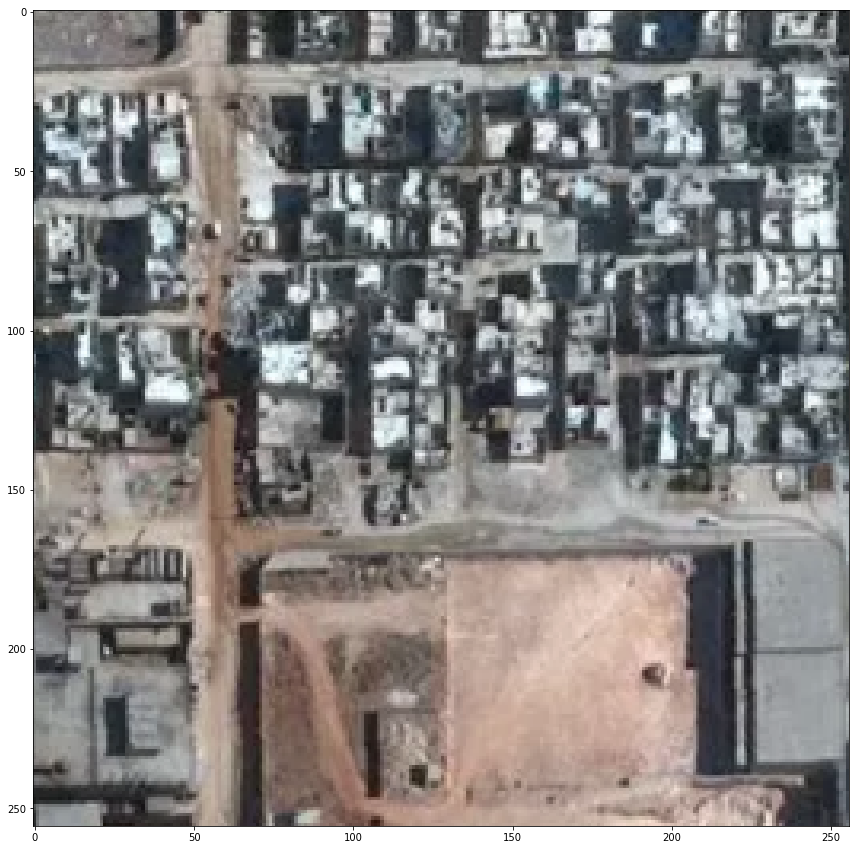

In [6]:
crop = np.array(Image.open(before))[:256, -256:]
plt.figure(figsize=(15, 15))
plt.imshow(crop)
plt.show()

forward pass

In [7]:
out = model.predict(np.expand_dims(crop, axis=0))

create mask from prediction

In [8]:
img = Image.fromarray(crop)
mask = np.zeros((256, 256, 3), dtype=np.uint8)
tmp = copy.deepcopy(out[0,...,0])
tmp[tmp>0.1] = 255
mask[:,:,0] = tmp
mask = Image.fromarray(mask)

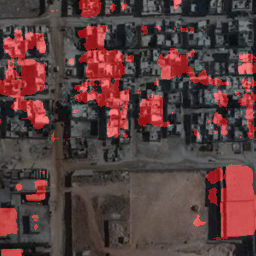

In [9]:
Image.blend(img, mask, 0.5)